# NHL Draft dataset
# Statistical Tests on data from the NHL API
This notebook presents statistical tests performed on the NHL Draft data obtained from NHL Records API. Previous steps included data collection and data cleaning.

### Data collection summary
Dataset generated from a JSON received from the NHL Records API, contains response to the request for all draft records.  

For details, see notebook `notebooks/feature_extraction/nhl_api.ipynb`.

### Data cleanup summary
* fixed capitalizations for Amateur Club Names, Player Names
* fixed inconsistent team names for some Russian Amateur Club Names
    * e.g., 'Ska Leningrad', 'St. Petersburg Ska', 'Ska St. Petersburg', 'Leningrad Ska', 'St. Petersburg Ska St. Petersburg' was replaced with 'Ska'
    * team names fixed only for Ska, Ska2, Cska, and Cska 2
* fixed 2 erratic height values and 3 weight values (replaced with mean)
* fixed inconsistent names for Russian leagues
    * 'Russia', 'RUS', 'RUSSIA', 'RUSSIA-1' were changed to 'Russia'
    * 'RUSSIA-JR.', 'RUSSIA JR. 2' were changed to 'Russia-Jr.'
* removed redundant positions
    * all players who can play center are assumed to be centers
        * C/RW (17 players), C/LW (30 players), F (362 players) = C
    * player who can play both wings are assumed to play the right wing
        * LW/RW (13 players) = RW
    * mixed D positions are assumed to be D
        * LW/D (1 player), D/F (1 player) = D
* filtered columns and renamed them to shorten their labels

* data problems identified but not currently addressed:
    * inconsistencies in some Amateur Club Names (e.g., 'London Knights' and 'London')
    * `pickInRound` appears to have erratic values (will be addressed in this notebook)

* data problems potentially present (not verified)
    * inconsistent names for Russian teams other than CSKA and SKA (those were fixed)

For details, see notebook `notebooks/feature_extraction/nhl_draft_api_cleanup.ipynb`

### Types of Statistical Hypothesis Tests

From [machinelearningmastery.com](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/):

There are hundreds of statistical hypothesis tests available, with multiple types of tests available for a given concern, answers that they give to a question are probabilistic in their nature rather than exact. Some of the commonly used ones in Machine Learning include:

* Normality Tests
    * Shapiro-Wilk Test
    * D’Agostino’s $K^2$ Test
    * Anderson-Darling Test
* Correlation Tests
    * Pearson’s Correlation Coefficient
    * Spearman’s Rank Correlation
    * Kendall’s Rank Correlation
    * Chi-Squared Test
* Parametric Statistical Hypothesis Tests
    * Student’s t-test
    * Paired Student’s t-test
    * Analysis of Variance Test (ANOVA)
    * Repeated Measures ANOVA Test
* Nonparametric Statistical Hypothesis Tests
    * Mann-Whitney U Test
    * Wilcoxon Signed-Rank Test
    * Kruskal-Wallis H Test
    * Friedman Test

### Characteristics of each test
    
Each test has its application scope, assumptions, and interpretation of results.

_Note_, when it comes to assumptions such as the expected distribution of data or sample size, the results of a given test are likely to degrade gracefully rather than become immediately unusable if an assumption is violated.

### Requirements to data samples

Generally, data samples need to be representative of the domain and large enough to expose their distribution to analysis.

In some cases, the data can be corrected to meet the assumptions, such as correcting a nearly normal distribution to be normal by removing outliers, or using a correction to the degrees of freedom in a statistical test when samples have differing variance, to name two examples.

In the case of NHL Draft dataset, we have complete draft records for 2009-2018 NHL Draft seasons, so these records represent a **full population of players drafted to the NHL from 2009 to 2018.**


## Preparations
### Import dependencies

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import shapiro, norm, normaltest
from time import time
import sys
import os
print("Required Python modules imported!")

Required Python modules imported!


In [3]:
os.chdir('Documents/repos/nhl_draft/')
sys.path.append('src/')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 'data',
 'design',
 'main.py',
 'models',
 'notebooks',
 'README.md',
 'requirements.txt',
 'src']

In [4]:
from io_utils import csv_to_df, csv_to_df_rec
from stests_utils import fit_norm_dist
print("User functions imported!")

User functions imported!


### Load data
#### NHL Draft data

In [5]:
file = 'data/nhl_api/nhl_draft_all_cleaned.csv'
df = csv_to_df(file)

----- DataFrame with NHL Draft Data loaded
in 0.09 seconds
with 11,587 rows
and 15 columns
-- Column names:
 Index(['name', 'nat', 'dob', 'bp', 'ateam', 'league', 'year', 'dteam',
       'overall', 'removed', 'why', 'height', 'weight', 'pos', 'shoots'],
      dtype='object')


#### NHL Records data: Most Goals in a Single Season by a Rookie

In [6]:
rec_name = 'most-goals-rookie-one-season'
suffix = '_new_cols'
dfr = csv_to_df_rec(rec_name, suffix)

----- NHL Records
--- Most Goals, Rookie, Season 

----- DataFrame with NHL Records Data loaded
in 0.11 seconds
with 3,377 rows
and 59 columns
-- Column names:
 Index(['activePlayer', 'assists', 'assistsPerGpMin20', 'firstGoals',
       'firstName', 'fiveGoalGames', 'fourGoalGames', 'gameWinningGoals',
       'gamesInSchedule', 'gamesPlayed', 'goals', 'goalsPerGpMin20',
       'goalsPerGpMin50', 'id', 'lastName', 'overtimeAssists', 'overtimeGoals',
       'overtimePoints', 'penalties', 'penaltyMinutes', 'playerId', 'points',
       'pointsPerGpMin50', 'positionCode', 'powerPlayGoals', 'rookieFlag',
       'seasonId', 'sevenGoalGames', 'shorthandedGoals', 'shots',
       'sixGoalGames', 'teamAbbrevs', 'teamNames', 'threeGoalGames',
       'threeOrMoreGoalGames', 'assists_norm', 'firstGoals_norm',
       'gameWinningGoals_norm', 'gamesPlayed_norm', 'goals_norm',
       'overtimeGoals_norm', 'overtimePoints_norm', 'penalties_norm',
       'penaltyMinutes_norm', 'points_norm', 'powerPlayGo

## Normality tests
This section lists statistical tests that you can use to check if data has a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution).

Normality tests can be used to check if the data has a [Gaussian (normal) distribution](http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn.html). 
### Gaussian (normal) distribution, a.k.a. bell curve
* Gaussian distribution can serve as an appropriate approximation for physical events in cases when the number of events is very large. 
* It can provide an excellent approximation to a number of practical situations.
* The Gaussian distribution is a _continuous_ function which approximates the exact [binomial distribution](http://hyperphysics.phy-astr.gsu.edu/hbase/Math/disfcn.html#c2) of events.
* The main properties are that the normal distribution is symmetric about its mean, and decreasing in both directions from the center. 
    * Though this is true of other distributions as well, these signals are often enough to conclude the normal distribution is a good approximation.
* The normal distribution is sometimes informally called the bell curve. 
    * However, **many other distributions are bell-shaped** (such as the Cauchy, Student's t-, and logistic distributions).

The **probability density function (PDF)** of the normal distribution is defined as:

$ P(x) = \frac{1} {\sqrt{2 \sigma^2 \pi}}$$e^{ - \frac{(x - \mu)^2} {2 \sigma^2}}$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution. The function has its peak at the mean and its "spread" increases with the standard deviation.

The normal distribution is useful because of the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). In its most general form, under some conditions (which include finite variance), it states that averages of samples of observations of random variables independently drawn from independent distributions converge in distribution to the normal, that is, they become normally distributed when the number of observations is sufficiently large.

### Normality tests check if data has a Gaussian distribution
The assumption of normality needs to be checked for many statistical procedures, namely parametric tests, because their validity depends on it. Visual inspection of the distribution may be used for assessing normality, although this approach is usually unreliable and does not guarantee that the distribution is normal.

From visually fitting the normal curve and comparing the predicted number of records within range with actual values, Gaussian distribution appears to be a good fit for the distributions of player height and weight. This result appears to be reasonable, given that there are 11'502 records in the NHL draft dataset, which is a fairly high number, and in these cases Gaussian distribution provides a good fit.

At the same time, number of goals (from Most Goals in a Single Season by a Rookie from the NHL Records API) and number of games played (same dataset) do not appear to be normally distributed, and thus checks performed above show that Gaussian distribution offers a poor fit to these variables.

To validate these results, normality tests can be conducted to determine if data follows a Gaussian distribution.

Normality Tests include:
* Shapiro-Wilk Test
* D’Agostino’s K^2 Test
* Anderson-Darling Test

#### Shapiro-Wilk Test
The Shapiro–Wilk test is a **test of normality in frequentist statistics.** It was [published in 1965](https://academic.oup.com/biomet/article-abstract/52/3-4/591/336553?redirectedFrom=fulltext) by Samuel Sanford Shapiro and Martin Wilk.
The Shapiro-Wilk test **calculates** a $W$ **statistic** that **tests whether a random sample**, $x_1,x_2,…,x_n$ **comes from (specifically) a normal distribution**. **Small values** of $W$ are evidence of **departure from normality**.

The $W$ statistic is calculated as follows:
$ W = \large{ \frac { \sum _{i=1}^{n}  a_i x_{(i)}} {\sum_{i=1}^n (x_i - \bar{x} )^2 } } $,
  
where 
* $x_{(i)}$ (with parentheses enclosing the subscript index $i$; not to be confused with $x_{i}$) is the $i^{th}$ order statistic, i.e., the $i^{th}$-smallest number in the sample (ordered sample values)
* $ \bar{x} = \frac{ \left( x_1 + \cdots + x_n \right) } {n} $ is the sample mean.
* $a_i$ are constants generated from the means, variances and covariances of the order statistics of a sample of size n from a normal distribution (see Pearson and Hartley (1972, Table 15).  
The coefficients $a_{i}$ are [given by](https://academic.oup.com/biomet/article-abstract/52/3-4/591/336553?redirectedFrom=fulltext):  
$(a_1, \dots, a_n) = \frac{ m^T V^{-1} } {C} $  
where C is a vector norm:  
$ C = || V^{-1}m || = (m^T V^{-1} V^{-1} m)^{1/2}$  
and the vector $m$,  
$ m = (m_1, \dots, m_n)^T $  
is made of the expected values of the order statistics of independent and identically distributed random variables sampled from the standard normal distribution; finally, $V$ is the covariance matrix of those normal order statistics.

From [statistics4u.info](http://www.statistics4u.info/fundstat_eng/ee_shapiro_wilk_test.html):

The [Shapiro-Wilk test](https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm)  is a test for normal distribution exhibiting high power, leading to good results even with a small number of observations. In contrast to other comparison tests the Shapiro-Wilk test is only applicable to check for normality.

The basis idea behind the Shapiro-Wilk test is to estimate the variance of the sample in two ways: (1) the regression line in the QQ-Plot allows to estimate the variance, and (2) the variance of the sample can also be regarded as an estimator of the population variance. Both estimated values should approximately equal in the case of a normal distribution and thus should result in a quotient of close to 1.0. If the quotient is significantly lower than 1.0 then the null hypothesis (of having a normal distribution) should be rejected.


**Assumptions**

Observations in each sample are independent and identically distributed (iid).

**Interpretation**

**H0:** the sample has a Gaussian distribution.  
**H1:** the sample does not have a Gaussian distribution.

The **null-hypothesis** of this test is that the **population is normally distributed**. Thus, on the one hand, **if the p-value** is **less than the chosen alpha level**, then the **null hypothesis is rejected** and there is evidence that the **data tested are not normally distributed**. 

On the other hand, if the **p-value** is **greater than the chosen alpha level**, then the null hypothesis that the **data came from a normally distributed population** can not be rejected. 

E.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population). Like most statistical significance tests, **if the sample size is sufficiently large** this **test may detect even trivial departures from the null hypothesis** (i.e., although there may be some statistically significant effect, it may be too small to be of any practical significance); thus, additional investigation of the effect size is typically advisable, e.g., a Q–Q plot in this case.

#### D’Agostino’s $K^2$ Test
In statistics, D’Agostino’s $K^2$ test, named for Ralph D'Agostino, is a **goodness-of-fit measure of departure from normality**, that is the test aims to establish whether or not the given **sample comes from a normally distributed population**. The test is **based on transformations of the sample kurtosis and skewness**, and has **power only against the alternatives that the distribution is skewed and/or kurtic.** It is based on [D’Agostino](https://www.researchgate.net/publication/253356685_An_Omnibus_Test_of_Normality_for_Moderate_and_Large_Size_Samples) and Pearson’s  test that combines skew and kurtosis to produce an omnibus test of normality.

##### Skewness and kurtosis
In the following, $\{ x_i \}$ denotes a sample of $n$ observations, $g_1$ and $g_2$ are the **sample skewness and kurtosis**, $m_j$’s are the $j^{th}$ sample central moments, and $\bar {x}$ is the sample mean. Frequently in the literature related to normality testing, the skewness and kurtosis are denoted as √β1 and β2 respectively. Such notation can be inconvenient since, for example, √β1 can be a negative quantity.

The sample **skewness and kurtosis are defined as**:  
${\begin{aligned}&g_{1}={\frac  {m_{3}}{m_{2}^{{3/2}}}}={\frac  {{\frac  {1}{n}}\sum _{{i=1}}^{n}\left(x_{i}-{\bar  {x}}\right)^{3}}{\left({\frac  {1}{n}}\sum _{{i=1}}^{n}\left(x_{i}-{\bar  {x}}\right)^{2}\right)^{{3/2}}}}\ ,\\&g_{2}={\frac  {m_{4}}{m_{2}^{{2}}}}-3={\frac  {{\frac  {1}{n}}\sum _{{i=1}}^{n}\left(x_{i}-{\bar  {x}}\right)^{4}}{\left({\frac  {1}{n}}\sum _{{i=1}}^{n}\left(x_{i}-{\bar  {x}}\right)^{2}\right)^{2}}}-3\ .\end{aligned}}$

These quantities consistently estimate the theoretical skewness and kurtosis of the distribution, respectively. Moreover, if the sample indeed comes from a normal population, then the exact finite sample distributions of the skewness and kurtosis can themselves be analysed in terms of their means $μ_1$, variances $μ_2$, skewnesses $γ_1$, and kurtoses $γ_2$. This has been done [by Pearson (1931)](https://academic.oup.com/biomet/article-abstract/22/3-4/423/225421?redirectedFrom=fulltext).
##### Transformed sample skewness and kurtosis
The sample skewness $g_1$ and kurtosis $g_2$ are both asymptotically normal. However, the rate of their convergence to the distribution limit is frustratingly slow, especially for $g_2$. For example even with $n = 5000$ observations the sample kurtosis $g_2$ has both the skewness and the kurtosis of approximately $0.3$, which is not negligible. In order to remedy this situation, it has been suggested to transform the quantities $g_1$ and $g_2$ in a way that makes their distribution as close to standard normal as possible.

In particular, D’Agostino (1970) suggested the following transformation for sample skewness:

$ {\displaystyle Z_{1}(g_{1})=\delta \operatorname {asinh} \left({\frac {g_{1}}{\alpha {\sqrt {\mu _{2}}}}}\right),}$  

where constants α and δ are computed as

$\begin{aligned}&W^{2}={\sqrt {2\gamma _{2}+4}}-1,\\&\delta =1/{\sqrt {\ln W}},\\&\alpha ^{2}=2/(W^{2}-1),\end{aligned}$

and where $μ_2 = μ_2(g_1)$ is the variance of $g_1$, and $γ_2 = γ_2(g_1)$ is the kurtosis — the expressions given in the previous section.

Similarly, Anscombe & Glynn (1983) suggested a transformation for g2, which works reasonably well for sample sizes of 20 or greater:

$Z_{2}(g_{2})={\sqrt  {{\frac  {9A}{2}}}}\left\{1-{\frac  {2}{9A}}-\left({\frac  {1-2/A}{1+{\frac  {g_{2}-\mu _{1}}{{\sqrt  {\mu _{2}}}}}{\sqrt  {2/(A-4)}}}}\right)^{{\!1/3}}\right\},$

where

$ A=6+{\frac  {8}{\gamma _{1}}}\left({\frac  {2}{\gamma _{1}}}+{\sqrt  {1+4/\gamma _{1}^{2}}}\right),$

and $μ_1 = μ_1(g_2)$, $μ_2 = μ_2(g_2)$, $γ_1 = γ_1(g_2)$ are the quantities computed by Pearson.
##### Omnibus $K^2$ statistic
Statistics $Z_1$ and $Z_2$ **can be combined to produce an omnibus test**, able to **detect deviations from normality due to either skewness or kurtosis** (D’Agostino, Belanger & D’Agostino 1990):

$K^{2}=Z_{1}(g_{1})^{2}+Z_{2}(g_{2})^{2}\,$

**If the null hypothesis of normality is true**, then $K^2$ is approximately $χ^2$**-distributed** with 2 degrees of freedom.

Note that the statistics $g_1$, $g_2$ **are not independent, only uncorrelated.** Therefore, **their transforms** $Z_1$, $Z_2$ **will be dependent also** (Shenton & Bowman 1977), **rendering the validity of** $χ_2$ **approximation questionable**. 

Simulations show that under the null hypothesis the $K^2$ test statistic is characterized by

|sample size           |expected value|standard deviation|95% quantile|
|----------------------|--------------|------------------|------------|
|n = 20	               | 1.971        |	2.339            |	6.373 |
|n = 50	               | 2.017        |	2.308            |	6.339 |
|n = 100               | 2.026        |	2.267            |	6.271 |
|n = 250	           | 2.012	      | 2.174            |  6.129 |
|n = 500	           | 2.009	      | 2.113            |	6.063 |
|n = 1000  	           | 2.000        |	2.062            |	6.038 |
|$χ^2(2)$ distribution | 2.000        |	2.000            |	5.991 |

#### Fitting a range of distributions and testing for goodness of fit


#### Player heights
Since there is a fairly large number of records in the NHL Draft dataset, normal curve appears to be a good fit for player heights.

Distribution of player heights

Using normal distribution, from the total 11,587 records in the Series, 11,060 are expected to have 68.49 < height < 76.84 

Actual number of records with 68.49 < height < 76.84: 10,863

----- Shapiro-Wilks normality test results:
W = 0.980, p-value = 0.000

----- D’Agostino’s K^2 normality test results:
s^2 + k^2 = 6.389, p-value = 0.041,
where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest
and p-value is a 2-sided chi squared probability for the hypothesis test.


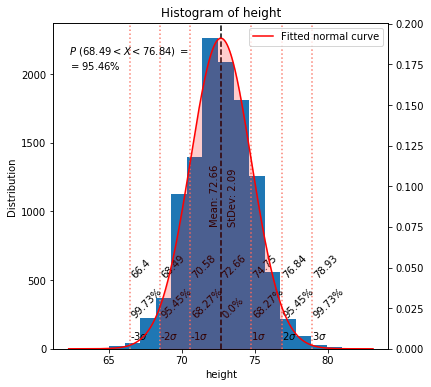

count    11502.000000
mean        72.664785
std          2.086986
min         65.000000
25%         71.000000
50%         73.000000
75%         74.000000
max         81.000000
Name: height, dtype: float64

In [18]:
def fit_norm_dist(series, h_bins='auto',
                  create_figure=True, ax=None,
                  show_plot=True, suptitle=None,
                  title=None, xlabel=None, ylabel='Distribution',
                  figsize=(6, 6), lab2='from_mean',
                  mean_lift=0.99, std_lift=1.007,
                  sig_lift=0.03, per_lift=0.1, val_lift=0.23,
                  x_between=None, x_min=None, x_max=None,
                  t_shapiro=True, t_k2=True):
    """

    :param series: pandas Series
        Series to be plotted
    :param h_bins: int
        number of bins to for histogram (default='auto')
    :param create_figure: Boolean
        whether to initialize matplotlib figure and axis
        (default=True)
    :param ax: matplotlib axis
        matplotlib axis to plot on (for multi-plot figures)
    :param show_plot: Boolean
        whether to show plot at the end (default=True)
    :param suptitle: string
        string to use for plot suptitle
    :param title: string
        string to use for plot title
    :param xlabel: string
        string to use for x axis label
    :param ylabel: string
        string to use for y axis label
    :param figsize: tuple(float, float)
        size of the figure
    :param lab2: string (must be 'cdf' or 'from_mean'
        which percentage values to display (CDF or from mean)
        (default='from_mean')
    :param mean_lift: float
        lift for mean caption
    :param std_lift: float
        lift for std caption
    :param sig_lift: float
        lift for sigma captions
    :param per_lift: float
        lift for percentage captions
    :param val_lift: float
        lift for values captions
    :param x_min: float
        estimate probability that x > x_min
    :param x_max: float
        estimate probability that x < x_max
    :param x_between: tuple(float, float)
        estimate probability that x_min < x < x_max
    :return: series.describe()
        statistical summary of the plotted Series
    """
    if create_figure:
        f, ax = plt.subplots(1, figsize=figsize)
        if suptitle:
            f.suptitle(suptitle)
    # plot data
    n, bins, patches = plt.hist(x=series, bins=h_bins)
    mu = series.mean()
    sigma = series.std()
    # initialize a normal distribution
    nd = norm(mu, sigma)
    # plot mean std
    ax.axvline(mu, color='black', linestyle='--')
    ax.text(mu * mean_lift, n.max() * 0.4,
            "Mean: {0:.2f}".format(mu),
            rotation='vertical')
    ax.text(mu * std_lift, n.max() * 0.4,
            "StDev: {0:.2f}".format(sigma),
            rotation='vertical')
    # generate sigma lines and labels
    i = np.arange(-3, 4)
    vlines = mu + i * sigma
    labels1 = pd.Series(i).astype('str') + '$\sigma$'
    if lab2 == 'cdf':
        labels2 = pd.Series(nd.cdf(vlines) * 100) \
                      .round(2).astype('str') + '%'
    elif lab2 == 'from_mean':
        labels2 = pd.Series(abs(50 - nd.cdf(vlines) * 100) * 2) \
                      .round(2).astype('str') + '%'
    else:
        raise AttributeError("Parameter 'lab2' must be either set to 'cdf' or 'from_mean'")
    labels2 = labels2.astype('str')

    # plot sigma lines and labels
    for vline, label1, label2 in zip(vlines, labels1, labels2):
        # plot sigma lines
        if vline != mu:
            ax.axvline(vline, linestyle=':', color='salmon')
            ax.text(vline, n.max() * sig_lift, label1)
        ax.text(vline, n.max() * per_lift, label2, rotation=45)
        ax.text(vline, n.max() * val_lift,
                round(vline, 2), rotation=45)

    # fit a normal curve
    # generate x in range of mu +/- 5 sigma
    x = np.linspace(mu - 5 * sigma, mu + 5 * sigma,
                    1000)
    # calculate PDF
    y = nd.pdf(x)
    # plot fitted distribution
    ax2 = ax.twinx()
    ax2.plot(x, y, color='red', label='Fitted normal curve')
    ax2.legend(loc='best')
    ax2.set_ylim(0)

    if not xlabel:
        xlabel = series.name
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if not title:
        title = "Histogram of {0}".format(series.name)
    ax.set_title(title)

    if x_min:
        # estimate probability that x > x_min
        p = (1 - nd.cdf(x_min)) * 100
        ax.text(mu - 5 * sigma, n.max() * 0.9, "$P ~ ( X > {0} ) ~ = $".format(x_min) +
                "\n$ = {0:.2f}\%$".format(p))
        ax2.fill_between(x, 0, y, color='red', alpha=0.2,
                         where=x > x_min)
        mask = series > x_min
        print("Using normal distribution, from the total {0:,} records in the Series, "
              "{1:,.0f} are expected to have {2} > {3}"
              .format(len(series), len(series) * p / 100, series.name, x_min),
              "\n\nActual number of records with {0} > {1}: {2:,}"
              .format(series.name, x_min, len(series[mask])))
    elif x_max:
        # estimate probability that x > x_min
        p = nd.cdf(x_max) * 100
        ax.text(mu - 5 * sigma, n.max() * 0.9, "$P ~ ( X < {0} ) ~ = $".format(x_max) +
                "\n$ = {0:.2f}\%$".format(p))
        ax2.fill_between(x, 0, y, color='red', alpha=0.2,
                         where=x < x_max)
        mask = series < x_max
        print("Using normal distribution, from the total {0:,} records in the Series, "
              "{1:,.0f} are expected to have {2} < {3}"
              .format(len(series), len(series) * p / 100, series.name, x_max),
              "\n\nActual number of records with {0} < {1}: {2:,}"
              .format(series.name, x_max, len(series[mask])))
    elif x_between:
        # estimate probability that x_min < x < x_max
        x_min, x_max = x_between
        p = (nd.cdf(x_max) - nd.cdf(x_min)) * 100
        ax.text(mu - 5 * sigma, n.max() * 0.9, "$P ~ ( {0} < X < {1} ) ~ = $".format(x_min, x_max) +
                "\n$ = {0:.2f}\%$".format(p))
        ax2.fill_between(x, 0, y, color='red', alpha=0.2,
                         where=np.logical_and(x > x_min, x < x_max))
        mask = np.logical_and(series < x_max, series > x_min)
        print("Using normal distribution, from the total {0:,} records in the Series, "
              "{1:,.0f} are expected to have {2} < {3} < {4}"
              .format(len(series), len(series) * p / 100, x_min, series.name, x_max),
              "\n\nActual number of records with {0} < {1} < {2}: {3:,}"
              .format(x_min, series.name, x_max, len(series[mask])))

    if show_plot:
        plt.show()

    if t_shapiro:
        stat, p = shapiro(series.dropna())
        print("\n----- Shapiro-Wilks normality test results:\nW = {0:.3f}, p-value = {1:.3f}"
              .format(stat, p))

    if t_k2:
        stat, p = normaltest(series.dropna())
        print("\n----- D’Agostino’s K^2 normality test results:"
              "\ns^2 + k^2 = {0:.3f}, p-value = {1:.3f},"
              .format(stat, p) + "\nwhere s is the z-score returned "
              "by skewtest and k is the z-score returned by kurtosistest"
              "\nand p-value is a 2-sided chi squared probability for the hypothesis test.")

    return series.describe()

col = 'height'
fit_norm_dist(df[col], h_bins=15, lab2='from_mean',
              x_between=(68.49, 76.84))
